# Lipkin model on a quantum computer

## FRIB-TA Summer School, Wed. June 22nd 2022

Congratulations, you've almost finished the summer school! This notebook will guide you through an analysis of the Lipkin model using a quantum computer. The Lipkin model is one of the foundational model systems of nuclear physics, and is simple enough so that you can cut your teeth on newly-learned quantum computing skills. 

We will focus on synthesizing the skills you've learned throughout the summer school. In particular, we will go through the process of 


1.   Mapping the fermionic Hamiltonian onto a spin system.
2.   Use VQE to obtain the ground state and ground state energy.
3.   Apply error mitigation to improve results.
4.   Compute the ground state energy using phase estimation. 

Some helpful resources for this activity include:


*   [Lipkin model on a quantum computer](https://arxiv.org/pdf/2011.04097.pdf)
*   [Dicke state preparation](https://arxiv.org/pdf/1904.07358.pdf)
*   [Naive ansatz](https://arxiv.org/pdf/2011.04097.pdf)
*   [One qubit per Dicke state ansatz](https://arxiv.org/pdf/2105.06761.pdf)
*   [Minimal qubit ansatz](https://arxiv.org/pdf/2203.01478.pdf)

## Imports

In [1]:
try:
  import qiskit
except ImportError:
  !pip install qiskit~=0.20.0 pylatexenc --quiet

import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np

# Lipkin model: The Hamiltonian


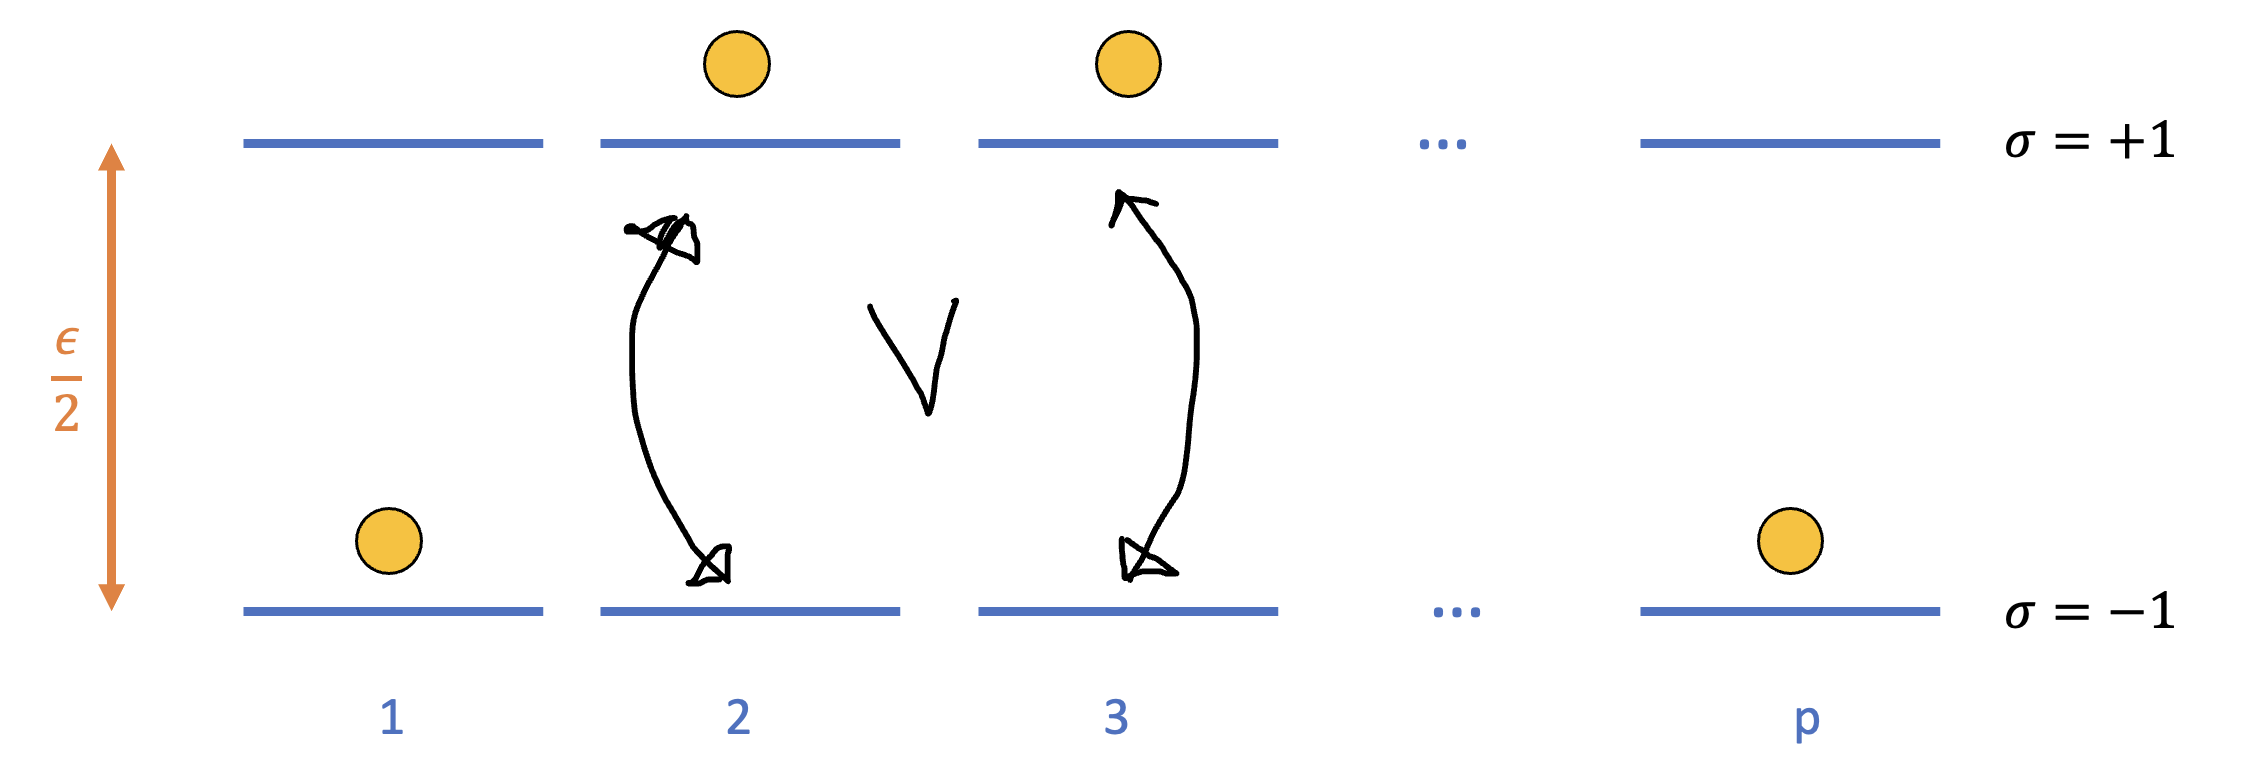


The Lipkin model is a fermionic Hamiltonian consisting of two energy levels, with separation energy $\epsilon$, and $N$ degenerate states in each level. The $2N$ states are occupied by $N$ fermions. Fermions can jump from states in the lower level to the upper level, and vice versa, in pairs. The system is described by the Hamiltonian

$$\tilde{H} = \frac{\epsilon}{2} \sum_{\sigma, p} \sigma c_{\sigma, p}^\dagger c_{\sigma, p} + \frac{V}{2}\sum_{\sigma, p, p'} c_{\sigma,p}^\dagger c_{\sigma,p'}^\dagger c_{-\sigma,p'} c_{-\sigma,p} $$

where $\sigma \in \{-1,1\}$ labels the two levels and $p = 1,2,\dots, N$ label the degenerate states in each level. 


**Sanity check** Consider each piece of the Hamiltonian $\tilde{H}$ and make sure its effect aligns with the description given above.

(Workspace)

When we want to use classical computers to numerically study such Hamiltonians, we need to convert $\tilde{H}$ to (say) a matrix, because this is how the computer stores information. Analogously, to study this system with quantum computers, we need to convert $\tilde{H}$ to an equivalent operation $H$ acting on qubits.

# Mapping to qubits: The Jordan Wigner transformation

The [Jordan Wigner (JW) transformation](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation) maps the algebra of fermionic creation and annihilation operators onto a set of qubits. Other mappings exist, though JW is most standard and relatively simple. 

The first ingredient to perform a JW transform is a suitable ordering of the fermionic states by a single index $j$. In our case, the multi-index $\{\sigma, p\}$ will be assigned to some $j$ from 1 to $2N$. The $j$ will label the qubits on our quantum computer, so there will be $2N$ qubits. The operator $c_j$ is then mapped as follows. 

$$ c_j \overset{JW}{\rightarrow} \sigma_j^{-} \prod_{k=1}^{j-1} Z_k$$

Here $\sigma^{-} = (X - i Y)/2$. In words, we take the spin lowering/raising operators with a chain of $Z$ gates to ensure proper anticommutation properties.


**Exercise** Verify that the JW-operators possess the correct anticommutation relations.

(Workspace)

Let's now map the Lipkin Hamiltonian $\tilde{H}$ to spins using JW. We must choose our ordering $j$. Any ordering will work, though for sake of efficient calculations, it is beneficial to choose an ordering such that *interacting states are as close together as possible in the JW ordering*. This will ensure the nonlocality introduced by the $Z$ chains is minimal (i.e. we want as few $Z$'s as possible).


**Exercise** Considering the Lipkin Hamiltonian, what is a good choice for the JW ordering? (Try to think about it a bit. The answer is below.)


In [ ]:
(Workspace)

**Answer** One "good" (less nonlocality) option is a zig zag pattern from $\{-1, p\} \rightarrow \{1, p\} \rightarrow \{-1, p+1\} \rightarrow \{1, p+1\} \rightarrow \dots \rightarrow \{-1, N\} \rightarrow \{1, N\}$.

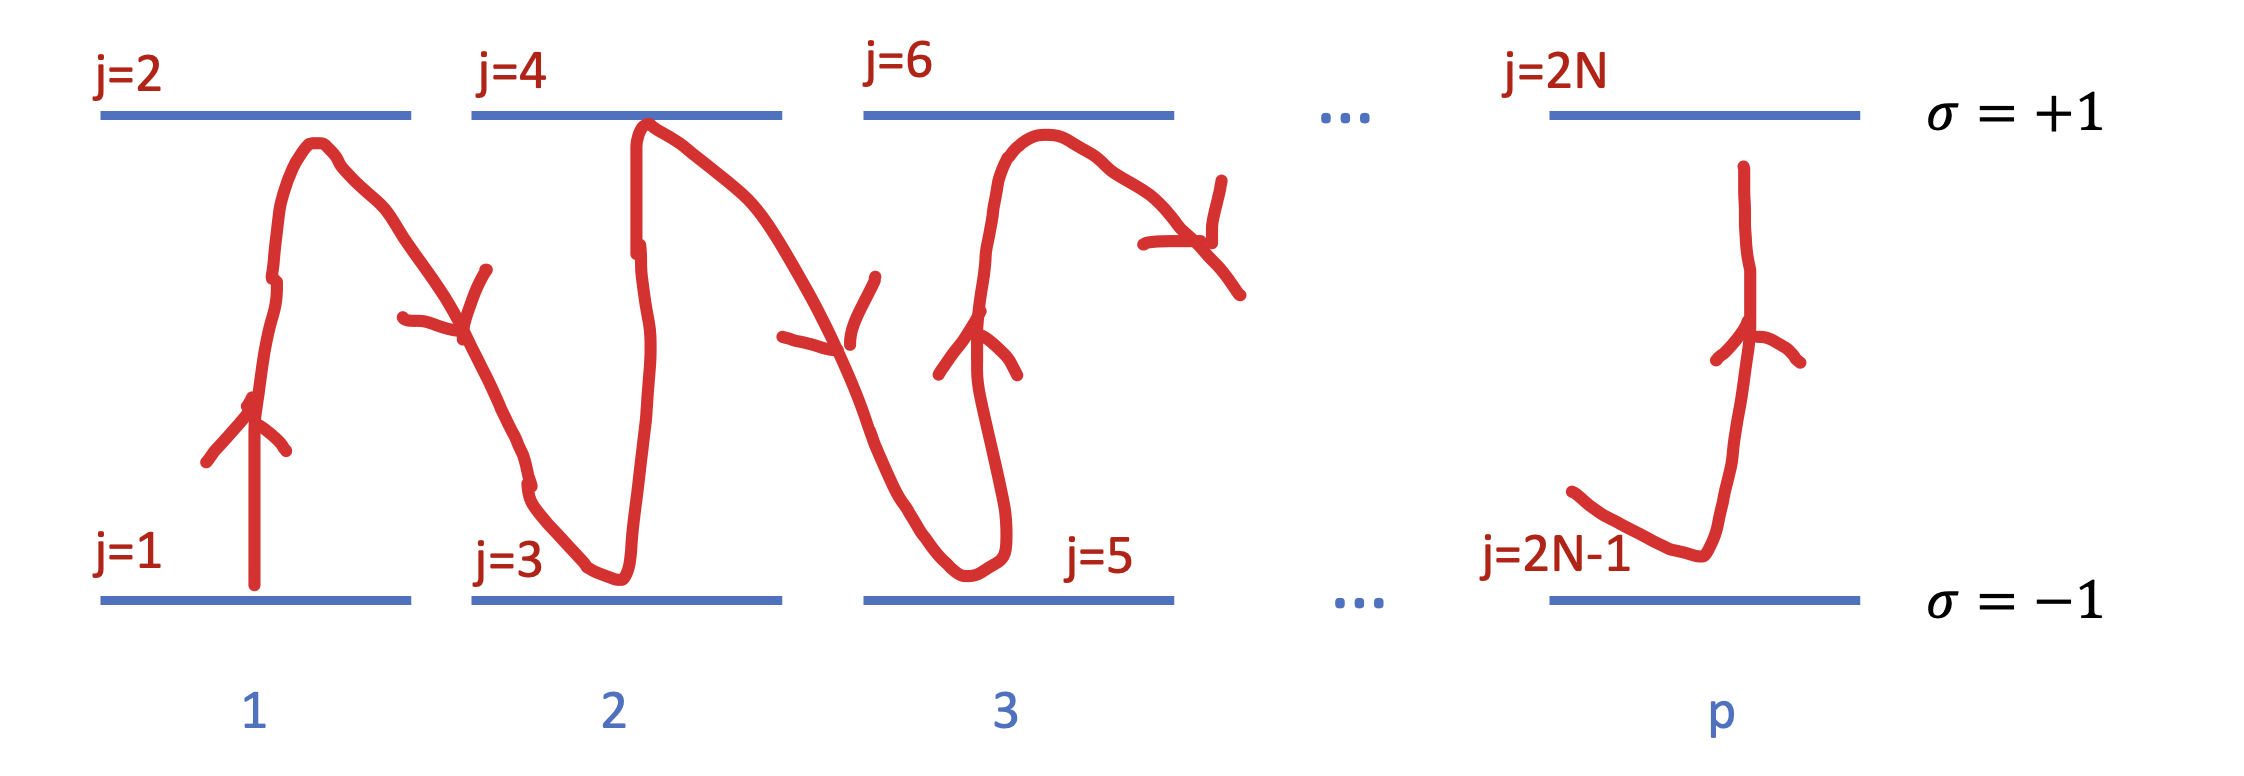

Now we will convert our fermionic Hamiltonian to spins using the JW scheme above. The first term in $\tilde{H}$ is easy: since the same index is used and $Z^2 = I$, all $Z$ strings cancel and we are left with $\sigma_j^+ \sigma_j^- = Z_j$ (up to an additive constant). Try to make sense of this yourself! 

The second term is a little trickier, and we walk you through how to find its JW form.

**Exercise** The interaction terms in $\tilde{H}$ take the form

$$c_{1,p}^\dagger c_{1,p'}^\dagger c_{-1,p'} c_{-1,p} + \text{h.c}$$

for $p' \neq p$. 

>a) Show that $c_{1,p}^\dagger c_{-1,p} \overset{JW}{\rightarrow} -\sigma_j^+ \sigma_{j-1}^-$, where $j = 2p$.


(Workspace)


>b) Use this to argue that 
\begin{align}
\sum_{p,p'} c_{1,p}^\dagger c_{1,p'}^\dagger c_{-1,p'} c_{-1,p} &= \sum_{j,k\;\text{even}}^{2N} \sigma_j^+ \sigma_{j-1}^- \sigma_k^+ \sigma_{k-1}^- = J_+^2
\end{align}
where
$$J_+ = \sum_{p = 1}^{N} \sigma_{2p}^+ \sigma_{2p-1}^-$$



>c) Using the above, show that the full Hamiltonian becomes
\begin{align}
  H = \epsilon J_0 + \frac{V}{2}(J_+^2 + J_-^2)
\end{align}
where
\begin{align}
  J_0 := \frac{1}{2}\sum_{p=1}^{N} \sigma_{2p}^+ \sigma_{2p}^- - \sigma_{2p-1}^+ \sigma_{2p-1}^-
\end{align}
and $J_- = J_+^\dagger$.

The choice of notation is not coincidental, indeed the operators, $J_0, J_\pm$ furnish a representation of the $SU(2)$ algebra. We may have started off with such an insight, but it is nevertheless valuable to practice using a general procedure such as JW.


### Further simplication using symmetry



As of now, our Hilbert space is of dimension $2^{2N} = 4^N$. However, we can take advantage of the fact that our $H$ conserves particle number. Even more helpful, each doublet of states labelled by $p$ conserves particle number. Since we assume $N$ fermions, one in each doublet $p$, there will always remain one particle in each doublet.


**Exercise** Argue that this means our state space is effectively of dimension $2^N$. Which states are in the "physical space" and which are not explored by $H$? Remember, each qubit represents an occupation number of the $2N$ possible states.

(Workspace)

We can use this to further reduce our Hamiltonian state space, by determining the matrix representation of the pieces of $H$ in the physical space.


**Exercise** By considering the matrix elements of $J_0$ in the subspace of interest, show that the induced Hamiltonian can be expressed on $N$ qubits as $\frac{1}{2}\sum_{p=1}^N Z_p$. Why does this result make sense?

(Workspace)

A similar method can be used to show the induced interaction Hamiltonian. Each term will have the form $X_p X_{p'}- Y_p Y_{p'}$. The total Hamiltonian is therefore reduced to 

$$\boxed{H = \frac{\epsilon}{2} \sum_{p=1}^N Z_p + \frac{V}{4} \sum_{p,p' = 1}^N X_{p} X_{p'} - Y_{p} Y_{p'}}$$.

The interpretation is elegant: each qubit refers to the $p$th doublet. Assuming $\epsilon >0$, a $|0\rangle$ means we're in the excited level, whereas $|1\rangle$ means we are in the lower level. (Sorry, the notation isn't great). 

# Dynamical simulation

Let us look to simulate the Lipkin model, which is represented by the boxed Hamiltonian above. The method we will use (indeed, the only one we've learned!), is Trotter. To do this as effectively as possible, we would like to split up $H$ into maximally commuting parts. 

As a first step, we can divide $H$ into the $H_0 + H_1$, where $H_0$ is the level energies represented by the pauli $Z$'s and $H_1$ is the interaction piece consisting of the $X$'s and $Y$'s. 

**Exercise** The Hamiltonian $H_0$ can be simulated right away. How would you do it? Construct a quantum circuit which does the simulation ($e^{itH_0}$)for time $t = 2$ and four qubits.

(Workspace)

In [ ]:
# Create quantum circuit here. Set epsilon to any value you like.
# epsilon = 1
qc = QuantumCircuit(___)
# ...



The interaction Hamiltonian $H_1$ is trickier, because it involves pairwise interactions between all pairs of qubits. Let's focus in on simulating one of the interactions: $XX - YY$ (tensor product omitted for simplicity). We've seen how to do this from previous lectures.

**Exercise** Using the [Smith et. al.](https://www.nature.com/articles/s41534-019-0217-0) paper as reference, construct a two-qubit gate which performs the unitary operation

$$ \exp\{-i (X\otimes X - Y\otimes Y)V t/4\}$$.

Encode the gate in a function definition, taking in the relevant parameters.

In [ ]:
def interact(V, t):
  qc = QuantumCircuit(__)
  ## INSERT GATES HERE
  




  ## Convert circuit to gate
  XXYY_gate = qc.to_gate()
  return XXYY_gate

Now we have the main ingredients, we just need to make a judicious choice of the ordering of the $XXYY$ interactions in the Trotterization. The problem has a fun reduction to the following: suppose there are $N$ people in an organization, and each person needs to meet every other person. Meetings must be one-on-one, and occur in rounds. There are plenty of rooms to accomodate simulataneous meetings within a given round. How can everyone meet in the shortest number of rounds?

As a lower bound, we require $N-1$ rounds since a person needs to meet $N-1$ other people (and meetings are 1-1). Can this be achieved? It turns out the answer is essentially yes: linear scaling in the rounds is achievable. (If you're curious, think about how you might do this). What this means is we only need $O(N)$ layers of $XX-YY$ gates, where $N$ is the number of qubits. 

For the purposes of this activity, we will take $N = 4$ and assume full connectivity between all the qubits.

:**Exercise**
Taking the number of qubits $N = 4$, describe a circuit which simulates $H_1$ using only three layers of the $XXYY$ simulators you constructed above.

(Workspace)

We are all set now to construct a full simulation of the Lipkin model! We will use $r$ trotter steps, so that each simulation step is $T/r$.

0
1
2


/usr/local/lib/python3.7/dist-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
/usr/local/lib/python3.7/dist-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to rev

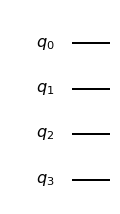

In [ ]:
# Simulation parameters
nqubits = 4 # Number of qubits
epsilon = 1 # Energy level gap
V = 1       # Interaction strength
T = 1       # Simulation time
r = 3       # Number of Trotter steps

dt = T/r    # Length of time step

lipkin_circ = QuantumCircuit(nqubits)

for i in range(r):
  # Simulate H_0
  print(i)
  # Simulate H_1

lipkin_circ.draw(output='mpl')

Now we can perform the time evolution! What we choose to do with this is up to us. Feel free to try different input states and measurements on the output, and see how it evolves in time.

# Phase estimation to determine spectrum


Now that we have the time evolution operator for the Lipkin Hamiltonian, we can use a routine like phase estimation to learn about the eigenvalues. In the previous notebook, we built up phase estimation "from scratch", but now we might as well use a built-in function provided by qiskit! See [this documentation](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseEstimation.html) for a description of the PhaseEstimation circuit, part of qiskit's Circuit Library.

**Exercise** Import the PhaseEstimation circuit. Run QPE using this built-in circuit. Run the circuit and observe the results. Can you interpret what you see? 

Perform an (classical) exact diagonalization of the $N=4$ Lipkin model (with your chosen parameters). Do the results match those obtained from phase estimation?

## VQE

### Two Qubits

To solve the LM on a quantum computer we have to solve Schrodinger's equation. 

\begin{equation}
    H|\psi(\tilde{\theta})\rangle = E|\psi(\tilde{\theta})\rangle\\
\end{equation}

One can take the LM Hamiltonian from equation (1) mapping the creation and annihilation operators to Pauli operators Z, X, Y using the Jordan-Wigner transformation. The Hamiltonian then takes the form of

\begin{equation}
      H = \frac{\epsilon}{2}(Z_1+Z_2) - \frac{V}{2}(X_1X_2 - Y_1Y_2)
\end{equation}

Where the Pauli operators are the measurement basis which the quantum circuit is measured in. However, before measuring, we first have to prepare the initial state $|\psi(\tilde{\theta})\rangle$ for $\Omega=2$ of the LM circuit

\begin{equation}
     |\psi(\tilde{\theta})\rangle = \cos(\tilde{\theta})|00\rangle+\sin(\tilde{\theta})|11\rangle
\end{equation}

Where $|00\rangle =|\uparrow\uparrow\rangle$, $|11\rangle=|\downarrow\downarrow\rangle$, and $\tilde{\theta}=\theta-\frac{\pi}{2}$.

This type of problem resides in the pantheon of variational methods where we minimize $\tilde{\theta}$. This problem was coded using IBM's python library Qiskit. Since this is a variational problem, the use of Qiskit's Variational Quantum Eigensolver (VQE) was used to find the optimal $\tilde{\theta}$ that minimizes $\langle\psi(\tilde{\theta})|H|\psi(\tilde{\theta})\rangle$.

### Arbitrary Qubits

A good ansatz for an arbitrary number of qubits ($n$) is:

$$ |\psi\rangle = \sum_{k=1}^nc_k|D^n_{2k}\rangle $$

where $|D^n_k\rangle$ is called a Dicke state and is defined as the equal superposition of bitstring with length $n$ and Hamming weight (number of 1s) $k$. For example:

$$ 
|D^4_2\rangle 
= 
\frac{1}{\sqrt{6}}\left(|1100\rangle+|1010\rangle+|1001\rangle+|0110\rangle+|0101\rangle+|0011\rangle\right) 
$$

##### Challenge idea

It is know how to efficiently take $|1...10...0\rangle$ to the Dicke state $|D^n_k\rangle$ where $k$ is the number of 1s and $n$ is the total length of the bitstring. So we've reducted the problem to preparing the state

$$
|\psi\rangle 
=
c_2|11\rangle\otimes|0...0\rangle + c_4|1111\rangle\otimes|0...0\rangle +
c_6|111111\rangle\otimes|0...0\rangle + ... +
c_n|1...1\rangle
$$

Can you create a circuit that prepares this on linear connectivity in linear depth.

### State preparation

The Lipkin model can actually be mapped such that a good ansatz is of the form:

$$
|\psi\rangle = \sum_{n=1}^Nc_n|(2^n)_2\rangle
$$

where the $c_n$ are complex numbers and

$$
|(2^n)_2\rangle = |0...010...0\rangle
$$

where the 1 is at the $n^\text{th}$ index from the right. Basically, the ket contains the bitstring corresponding to the binary number corresponding to the base 10 number $2^n$. For example, for N = 3:

$|\psi\rangle = c_0|001\rangle + c_1|010\rangle + c_2|100\rangle$

Hint, the following quantum circuit $U$:

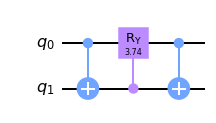

In [13]:
q = QuantumRegister(2,'q')
circ = QuantumCircuit(q)

theta = np.random.uniform(0,2*np.pi)

circ.cx(q[0],q[1])
circ.cry(theta,q[1],q[0])
circ.cx(q[0],q[1])

circ.draw('mpl')

has the following action

$$
\begin{align}
U|00\rangle &= |00\rangle \\
U|01\rangle &= \cos\theta/2|01\rangle + \sin\theta/2|10\rangle \\
U|10\rangle &= \cos\theta/2|10\rangle - \sin\theta/2|01\rangle \\
U|11\rangle &= |11\rangle
\end{align}
$$

##### Challenge idea:

Potential final challenge idea: Design quantum circuit that prepares this ansatz. Note that the coeficients $c$ are note specified and so can be whatever you want them to be. Try to prepare it for some small $N$ and/or try to write a function that prepares it for any $N$. Assuming linear connectivity, this can be achieved with a depth of $N-1$ two-qubit gate coloumns or $(N-1)/2$, if you're clever. Would circular connectivity help you at all? With all-to all connectivity, it can actually do it with depth $\mathcal{O}(\log{N})$. Finding any of these quantum circuits would be impressive! No cheating by Googling the answer!

Another ansatz to look at would be the GHZ state:

$|\psi\rangle = c_0|0...0\rangle + c_1|1...1\rangle $

where the length of each bitstring ($0...0$ and $1...1$) is $N$. Try to prepare it for some small $N$ and/or try to write a function that prepares it for any $N$. This can be done in linear depth for linear connectivity and logarithmic depth for all-to-all connectivity. Can you find either?

**That's it!** Feel free to explore this model in greater depth however you choose, or consider it a job well done. 

## Final Challenge

Congratulations on making it this far! We're going to end the summer school with a little challenge. The winner will win a prize! We're going to evaluate based on creativity, demonstration of knowledge, and execution. Your project can be anything you want, but here are a few suggestions:

- Make an instructional notebook introducing the basics of quantum computing (gates, entanglement, gate decomposition, etc.) or a simple quantum algorithm.
- Extend a previous notebook to a larger or more complicated system.
- Apply time evolution (Hamiltonian simulation) to a simple model, pairing model, lipkin model, etc.
- Apply phase estimation to a simple model, pairing model, lipking model, etc.
- Run a noisy simulation of anything you've previously done and impliment error mitigation.
- Work out how to efficiently prepare a certain ansatz for different qubit-connectivities.
- Anything else that has to do with quantum computing and/or many-body nuclear physics.

Good luck!